In [1]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import umap
from sentence_transformers import SentenceTransformer, util
from bokeh.plotting import show, save, output_notebook, output_file

In [2]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [3]:
ds = pd.read_csv('https://raw.githubusercontent.com/LuisSante/Datasets/main/app_reviews.csv')
ds

,package_name,review,date,star
0,com.mantz_it.rfanalyzer,Great app! The new version now works on my Bra...,October 12 2016,4
1,com.mantz_it.rfanalyzer,Great It's not fully optimised and has some is...,August 23 2016,4
2,com.mantz_it.rfanalyzer,Works on a Nexus 6p I'm still messing around w...,August 04 2016,5
3,com.mantz_it.rfanalyzer,The bandwidth seemed to be limited to maximum ...,July 25 2016,3
4,com.mantz_it.rfanalyzer,Works well with my Hackrf Hopefully new update...,July 22 2016,5
...,...,...,...,...
288060,com.termux.api,it doesn't do anything after installing this i...,June 24 2016,3
288061,com.termux.api,I like this app . Its is very helpful for use....,June 20 2016,5
288062,com.termux.api,Finally Brings back the Unix command line to A...,May 20 2016,5
288063,com.termux.api,The API feature is great just need loads more...,May 05 2016,5


In [4]:
list_ = []  
for i in range(len(ds['package_name'].unique())):
    ds_aux = ds.loc[ds['package_name'] == ds['package_name'].unique()[i]]
    #rescatamos en list_ los packages names unicos de todo el dataset
    list_.append({'package_name':ds['package_name'].unique()[i], 'size': len(ds_aux)})

#ordenamos de acuerdo al numero de datos de cada package name (de mayor a menor)
list_ = sorted(list_, key=lambda x: x['size'], reverse=True)

#seleccionamos el package name # 40 y almacenamos los reviews en el corpus
df = ds[ds['package_name'] == list_[40]['package_name']]
corpus = list(df['review'])

corpus_ds = {
    'Sentences' : corpus
}

ds_new = pd.DataFrame(corpus_ds)
print(ds_new)

                                              Sentences
0     Amazing Its great but can someone explain to m...
1     Seems this is one of the best app although I d...
2     Great; needs material design UI. Please use ma...
3                                             Great app
4                                          Cathy Female
...                                                 ...
1090  First time experimenting with this theorpy in ...
1091  Tried and true...no frills without the bells a...
1092                            One of the best so far.
1093              I quit smoking with the self hypnosis
1094   Helps me focus on work with kids running around!

[1095 rows x 1 columns]


In [5]:
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

In [6]:

def best_cluster_agglomerative(j):
    best_k = 0
    best_average = 0
    for k in range(2,j):
        agglomerative_clusterering = AgglomerativeClustering(n_clusters=k, affinity="cosine" , linkage="complete")
        cluster_labels = agglomerative_clusterering.fit_predict(corpus_embeddings)

        silhouette_avg = silhouette_score(corpus_embeddings, cluster_labels)
    
        if(silhouette_avg > best_average): 
            best_average = silhouette_avg
            best_k = k
            #ds_new['clusters'] = cluster_labels

        #print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)
        #print(cluster_labels)
    return best_k, best_average

In [7]:
best_k_HC, best_average_HC = best_cluster_agglomerative(10)
print(best_k_HC)

7


In [8]:
clustering_model = AgglomerativeClustering(n_clusters=best_k_HC, affinity="cosine" , linkage="complete") #, affinity='cosine', linkage='average', distance_threshold=0.4)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_
print(cluster_assignment)

[0 2 2 ... 5 0 2]


In [9]:
ds_new['clusters'] = cluster_assignment

In [10]:
ds_new = ds_new.sort_values(by=['clusters', 'Sentences'])
ds_new

,Sentences,clusters
67,-good: Beats organized by purpose: study focu...,0
17,A good one but... I used the Morphine pain ki...,0
848,A grateful new mom I love the power nap! No ma...,0
805,A must have with traveling I travel 40 to 45 w...,0
710,Absolutely love it!! Use quality in-ear phones...,0
...,...,...
844,love it,6
822,mind blowing everyone should try this piece of...,6
811,nice,6
1088,no thing to say.... love it!!,6


In [11]:
count = 0
for i in ds_new['Sentences'][ds_new['clusters'] == 0]:
    print(count , i ,end="\n")
    count+=1

0 -good: Beats organized by purpose: study  focus  sleep  meditate -able listen offline (or in subway) -timer not very effective -like """"""""""""""""highest mental activity"""""""""""""""" + """"""""""""""""creativity"""""""""""""""" + """"""""""""""""power nap""""""""""""""""...like Trance""
1 A good one  but... I used the Morphine pain killer and was a bit surprised to see a green color on the screen. Yes  we all know that green is the color of healing  but actually it stimulates the reproduction of all possible cells which bind our organism. That means the bad tumorous cells as well  in case we have cancer. That's why it is not a good color choice for that group of people. And who uses morphine more often than them? But leaving that aside  this is a great app!
2 A grateful new mom I love the power nap! No matter how long my son lays down for I always get a good nap. Thank you!
3 A must have with traveling I travel 40 to 45 weeks a year  the sleep rhythms are excellent  doesn't mat

In [12]:
corpus_embeddings

tensor([[-0.0013, -0.0005, -0.0202,  ...,  0.0973,  0.0784,  0.0276],
        [-0.0518, -0.0570, -0.0176,  ...,  0.1222,  0.0545,  0.0228],
        [-0.1153,  0.0048,  0.0092,  ...,  0.0089, -0.0132,  0.0656],
        ...,
        [-0.0558, -0.0251, -0.0603,  ..., -0.0306,  0.0625,  0.1036],
        [ 0.0870,  0.0763, -0.0306,  ..., -0.0333, -0.0735, -0.0481],
        [-0.0249,  0.0136,  0.0304,  ..., -0.0121, -0.0461,  0.1166]])

In [13]:
#A partir de aqui nos dedicaremos a plotear
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(corpus_embeddings)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

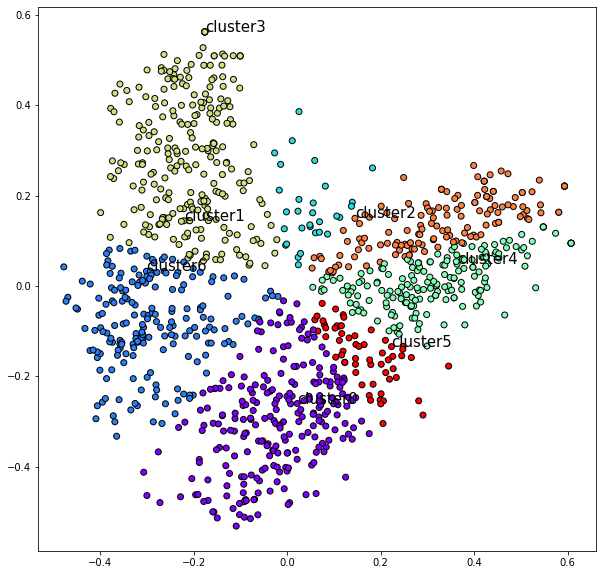

In [14]:

plt.figure(figsize =(10,10))

label_clusters = []
for i in range(best_k_HC):
    label_clusters.append("cluster" + str(i))

annotation = []
cluster = 0
for i in range(len(ds_new['Sentences'])):
    if(ds_new['clusters'][i] == cluster):
        annotation.append(ds_new['Sentences'][i])
        cluster+=1
    if(cluster == best_k_HC):
        break

#for i in annotation:
#    print(i , end="\n")

for i, label in enumerate(label_clusters):
    plt.annotate(label, (X_principal['P1'][i], X_principal['P2'][i]), fontsize=15, c="k")

scatter = plt.scatter(X_principal['P1'], 
                        X_principal['P2'],
                        c=clustering_model.fit_predict(X_principal),
                        cmap='rainbow',
                        edgecolor='k'
                    )

plt.show()